In [2]:
import numpy as np
import sympy as sym
from scipy import linalg
from scipy import signal
import time
import matplotlib.pyplot as plt
import imageio
import os

import ae353_drone
import importlib
importlib.reload(ae353_drone)

pybullet build time: Sep  2 2021 19:47:36


<module 'ae353_drone' from '/Users/amoghsrigopal/Downloads/DesignProblem04-1/code/ae353_drone.py'>

In [3]:
# parameters as given
m = sym.nsimplify(0.5)
J1 = sym.nsimplify(0.0023)
J2 = sym.nsimplify(0.0023)
J3 = sym.nsimplify(0.0040)
l = sym.nsimplify(0.175)
g = sym.nsimplify(9.81)

# As given from DeriveEOM

# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# roll, pitch, yaw angles (radians)
phi, theta, psi = sym.symbols('phi, theta, psi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m = sym.nsimplify(0.5)
Jx = sym.nsimplify(0.0023)
Jy = sym.nsimplify(0.0023)
Jz = sym.nsimplify(0.0040)
l = sym.nsimplify(0.175)
g = sym.nsimplify(9.81)

# rotation matrices
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Rxyz = Rx * Ry * Rz

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry * Rz).T * ex, Rz.T * ey, ez).inv(), full=True)

# applied forces
forces = sym.Matrix([[0], [0], [-m * g]]) + Rxyz * sym.Matrix([[0], [0], [f_z]])

# euler's equations
euler = sym.Matrix([[(1 / Jx) * (tau_x + (Jy - Jz) * w_y * w_z)],
                   [(1 / Jy) * (tau_y + (Jz - Jx) * w_z * w_x)],
                   [(1 / Jz) * (tau_z + (Jx - Jy) * w_x * w_y)]])

# equations of motion
f = sym.Matrix.vstack(sym.Matrix([[v_x], [v_y], [v_z]]),
                      M * sym.Matrix([[w_x], [w_y], [w_z]]),
                      (1 / m) * forces,
                      euler)
f = sym.simplify(f, full=True)

f

Matrix([
[                                                     v_x],
[                                                     v_y],
[                                                     v_z],
[                (w_x*cos(psi) - w_y*sin(psi))/cos(theta)],
[                             w_x*sin(psi) + w_y*cos(psi)],
[-w_x*cos(psi)*tan(theta) + w_y*sin(psi)*tan(theta) + w_z],
[                                        2*f_z*sin(theta)],
[                              -2*f_z*sin(phi)*cos(theta)],
[                     2*f_z*cos(phi)*cos(theta) - 981/100],
[                          10000*tau_x/23 - 17*w_y*w_z/23],
[                          10000*tau_y/23 + 17*w_x*w_z/23],
[                                               250*tau_z]])

In [4]:
# Set equilibrium values

p_xe = 0
p_ye = 0
p_ze = 0
phi_e = 0
theta_e = 0
psi_e = 0
v_xe = 0
v_ye = 0
v_ze = 0
w_xe = 0
w_ye = 0
w_ze = 0
tau_xe = 0
tau_ye = 0
tau_ze = 0
f_ze = 0.5*9.81


In [5]:
# Linearize

f_num = sym.lambdify((p_x, p_y, p_z, phi, theta, psi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z), f)
f_e = f_num(p_xe, p_ye, p_ze, phi_e, theta_e, psi_e, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze)

A_num = sym.lambdify((p_x, p_y, p_z, phi, theta, psi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z), f.jacobian([p_x, p_y, p_z, phi, theta, psi, v_x, v_y, v_z, w_x, w_y, w_z]))
B_num = sym.lambdify((p_x, p_y, p_z, phi, theta, psi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z), f.jacobian([tau_x, tau_y, tau_z, f_z]))

A = A_num(p_xe, p_ye, p_ze, phi_e, theta_e, psi_e, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze)
B = B_num(p_xe, p_ye, p_ze, phi_e, theta_e, psi_e, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze)
A = A.astype(float)
B = B.astype(float)
print("The A matrix is:")
print(A)
print(A.shape)
print("The B matrix is:")
print(B)
print(B.shape)

The A matrix is:
[[ 0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    1.   -0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.    0.    1.  ]
 [ 0.    0.    0.    0.    9.81  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -9.81  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.   -0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]
(12, 12)
The B matrix is:
[[  0.          0.          0.          0.       ]
 [  0

In [6]:
n = A.shape[0]
W = B
for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    W = np.block([W, col])
    
print(np.linalg.matrix_rank(W))
    
if np.linalg.matrix_rank(W) == n:
    print("Yes")
else:
    print("No")

12
Yes


In [7]:
def LQR(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @ B.T @ P
    return K

Q1 = np.diag([20, 43, 20, 13, 1, 1, 1, 1, 1, 1, 1, 1])
R1 = 20.*np.eye(4)
K = LQR(A, B, Q1, R1)

F = A-B @ K

print("The eigenvalues are:")
print(linalg.eigvals(F))
print("")
print("K is:")
print(K)
print(K.shape)

The eigenvalues are:
[-97.21525548+0.j         -97.15342551+0.j
 -55.89275159+0.j          -2.14145778+3.02888945j
  -2.14145778-3.02888945j  -3.18851096+0.j
  -2.40527485+2.98247932j  -2.40527485-2.98247932j
  -4.38490863+0.j          -1.00016009+0.j
  -1.02469508+0.97467943j  -1.02469508-0.97467943j]

K is:
[[-5.55588806e-16 -1.46628783e+00  7.51745600e-16  2.13703264e+00
   2.07096888e-16  2.12933036e-16 -1.21396225e-16 -8.29963211e-01
  -1.41576583e-16  2.44602433e-01  1.49289373e-18 -1.25346136e-16]
 [ 1.00000000e+00 -5.37064302e-17  8.83641518e-16  7.74669306e-16
   1.73363138e+00 -5.25052990e-16  6.35170582e-01 -1.65664118e-16
   1.41629348e-15  1.49289373e-18  2.40779369e-01  1.93563675e-17]
 [ 1.32464973e-15  5.11226823e-16 -2.03763754e-16 -7.24075379e-16
   1.26547044e-16  2.23606798e-01  1.62659095e-16  3.38127574e-16
   5.59806652e-17 -7.20740284e-17  1.11299113e-17  2.27571647e-01]
 [ 1.61099429e-16  5.91246304e-17  1.00000000e+00  2.84194631e-16
   4.34900217e-16  1.21820

In [8]:
if (np.real(linalg.eigvals(F)) < 0).all():
    print("Yes")
else: 
    print("No")

Yes


In [9]:
# Define G matrix and C

g = sym.Matrix([[p_x],[p_y],[p_z],[phi],[theta],[psi]])
g_num = sym.lambdify((p_x,p_y,p_z,phi,theta,psi),g)
g_e = g_num(p_xe,p_ye,p_ze,phi_e,theta_e,psi_e)

C_num = sym.lambdify((p_x,p_y,p_z,phi,theta,psi), g.jacobian([p_x,p_y,p_z,phi,theta,psi,v_x,v_y,v_z,w_x,w_y,w_z]))
C = C_num(p_xe,p_ye,p_ze,phi_e,theta_e,psi_e)
C = C.astype(float)

print(C)
print(C.shape)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
(6, 12)


In [10]:
M = A.shape[0]
O = B
for i in range(1, M):
    col = np.linalg.matrix_power(A, i) @ B
    O = np.block([O, col])
    
rank = np.linalg.matrix_rank(O)
print(rank)
print(O)

12
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  4.26521739e+03  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -4.2

In [10]:
if np.linalg.matrix_rank(W_0) == M:
    print('Yes')
else:
    print('No')

Yes


In [11]:
Q2 = 561*np.eye(6)
R2 = np.eye(12)
L = LQR(A.T, C.T, linalg.inv(R2), linalg.inv(Q2)).T
H = A-L@C
e2 = linalg.eigvals(H)

print(e2)

#Confirm stability

if (np.real(e2) < 0).all():
    print("Yes")
else:
    print("No")

print(L)

[-23.86925324+0.j -23.45383313+0.j  -1.08463979+0.j  -1.00000907+0.j
 -23.66428133+0.j -23.86925324+0.j -23.45383313+0.j -23.66428133+0.j
  -1.08463979+0.j  -1.00000907+0.j  -1.00089406+0.j  -1.00089406+0.j]
Yes
[[ 2.47433590e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.98539350e-01  0.00000000e+00]
 [ 0.00000000e+00  2.47433590e+01  0.00000000e+00 -1.98539350e-01
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.46651754e+01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.98539350e-01  0.00000000e+00  2.46643763e+01
   0.00000000e+00  0.00000000e+00]
 [ 1.98539350e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.46643763e+01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  2.46651754e+01]
 [ 2.56366151e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   9.80184873e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56366151e+01  0.00000000e+00 -9.80184873e+00
   0.00000000e+

In [12]:
simulator = ae353_drone.Simulator(display=True, pos_noise=0, rpy_noise=0, num_rings=2, ring_separation=5)

In [13]:
class RobotController:
    def __init__(self, limiter=None):
        self.dt = 0.01
        self.limiter = limiter 
        
        self.p_xe = p_xe
        self.p_ye = p_ye
        self.p_ze = p_ze
        self.phi_e = phi_e
        self.theta_e = theta_e
        self.psi_e = psi_e
        self.v_xe = v_xe
        self.v_ye = v_ye
        self.v_ze = v_ze
        self.w_xe = w_xe
        self.w_ye = w_ye
        self.w_ze = w_ze
        self.tau_xe = tau_xe
        self.tau_ye = tau_ye
        self.tau_ze = tau_ze
        self.f_ze = f_ze
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        
    def get_color(self):
        return [0., 1., 0.]
    
    def reset(self, pos):
        self.xhat = np.zeros(12).reshape((12,1))
        
    def run(self, pos, rpy, pos_ring, is_last_ring, pos_others):
        p_xdes = pos_ring[0]
        p_ydes = pos_ring[1]
        p_ydes = pos_ring[2]
        p_est = np.array([self.xhat[0],self.xhat[1],self.xhat[2]])
        p_est = p_est.T[0]


        error = pos_ring-p_est

        if abs(error[1]) > 2.0:
            p_xdes = p_est[0] + (3.0 * error[0]/(np.linalg.norm(error)))
            p_ydes = p_est[1] + (5.0 * error[1]/(np.linalg.norm(error)))
            p_zdes = p_est[2] + (10. * error[2]/(np.linalg.norm(error)))
        else:
            p_xdes = p_est[0] + (3.0 * error[0]/(np.linalg.norm(error)))
            p_ydes = p_est[1] + (3.0 * error[1]/(np.linalg.norm(error)))
            p_zdes = p_est[2] + (10. * error[2]/(np.linalg.norm(error)))

        if abs(pos[0]) < 2 and abs(pos[1]) < 2 and pos[2] < 1:
            p_zdes = 2.5
        elif is_last_ring == True:
            p_zdes = 1.0        
        
        xhat_des = np.array([[p_xdes-self.p_xe],[p_ydes-self.p_ye],[p_zdes-self.p_ze],[self.phi_e],[self.theta_e],[self.psi_e],[self.v_xe],[self.v_ye],[self.v_ze],[self.w_xe],[self.w_ye],[self.w_ze]])
        
        
        u = -self.K @ (self.xhat-xhat_des)
        print(u.shape)
        tau_x = u[0,0]+self.tau_xe
        tau_y = u[1,0]+self.tau_ye
        tau_z = u[2,0]+self.tau_ze
        f_z = u[3,0]+self.f_ze
        
        y = np.concatenate((pos,rpy),axis=None).reshape(6,1).astype(float)
        
        self.xhat += self.dt*(self.A@self.xhat+self.B@u-self.L@(self.C@self.xhat-y))

        if self.limiter is not None:
            tau_x, tau_y, tau_z, f_z = self.limiter(tau_x, tau_y, tau_z, f_z)
            
        
        return tau_x, tau_y, tau_z, f_z
    


In [14]:

simulator.add_drone(RobotController, 'asrigo2', 'my_image.png')
simulator.reset()
simulator.camera_droneview('asrigo2')
simulator.run(max_time= 45.0)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

In [15]:
drone_name = 'asrigo2' # drone name
drone = simulator.get_drone_by_name(drone_name) # get the internal drone object corresponding to the drone name

if drone is None:
    drone_names = '\n'.join([d['name'] for d in simulator.drones])
    msg = f'The simulator has no drone with name "{drone_name}".'
    if len(drone_names) == 0:
        msg += f' The simulator has no drones at all, in fact.'
    else:
        msg += f' The simulator has these drones:'
        msg += f'\n==========\n{drone_names}\n==========\n'
    print(msg)

In [16]:
data = drone['data'].copy()

In [17]:
for key in data.keys():
    if key != 'user_data':
        data[key] = np.array(data[key]).T
for key in data['user_data'].keys():
    data['user_data'][key] = np.array(data['user_data'][key]).T

In [18]:
if drone['finish_time'] is None:
    if drone['running']:
        print(f'The drone "{drone["name"]}" did not finish.')
    else:
        print(f'The drone "{drone["name"]}" did not finish and was no longer running.')
else:
    print(f'The drone "{drone["name"]}" finished with time: {drone["finish_time"]}')

The drone "asrigo2" finished with time: 5.99


KeyError: 'tau_x_des'

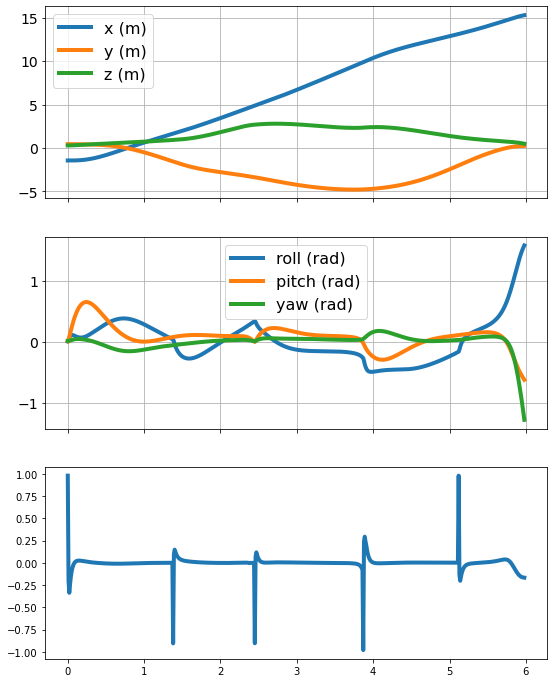

In [19]:
# Create a figure with subplots that all share the same x-axis
fig, (ax_pos, ax_rpy, ax_act) = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

# Position
ax_pos.plot(data['t'], data['pos'][0, :], label='x (m)', linewidth=4)
ax_pos.plot(data['t'], data['pos'][1, :], label='y (m)', linewidth=4)
ax_pos.plot(data['t'], data['pos'][2, :], label='z (m)', linewidth=4)
ax_pos.grid()
ax_pos.legend(fontsize=16)
ax_pos.tick_params(labelsize=14)

# Roll, pitch, and yaw angles
ax_rpy.plot(data['t'], data['rpy'][0, :], label='roll (rad)', linewidth=4)
ax_rpy.plot(data['t'], data['rpy'][1, :], label='pitch (rad)', linewidth=4)
ax_rpy.plot(data['t'], data['rpy'][2, :], label='yaw (rad)', linewidth=4)
ax_rpy.grid()
ax_rpy.legend(fontsize=16)
ax_rpy.tick_params(labelsize=14)

# Actuator commands
ax_act.plot(data['t'], data['tau_x'], label='tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['user_data']['tau_x_des'], '--', label='desired tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y'], label='tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['user_data']['tau_y_des'], '--', label='desired tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z'], label='tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['user_data']['tau_z_des'], '--', label='desired tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['f_z'], label='f_z (N)', linewidth=4)
ax_act.plot(data['t'], data['user_data']['f_z_des'], '--', label='desired f_z (N-m)', linewidth=4)
ax_act.grid()
ax_act.legend(fontsize=16)
ax_act.tick_params(labelsize=14)

# Set shared x-axis properties
ax_act.set_xlabel('time (s)', fontsize=20)
ax_act.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

In [20]:
simulator = ae353_drone.Simulator(display=False)

In [21]:
simulator.add_drone(RobotController, 'asrigo2', 'my_image.png')
simulator.reset()
simulator.camera_droneview('asrigo2')

In [22]:
finish_time = []
trials = 100
f = 0
s = 0

for trial in range(trials):
    simulator.move_rings()
    simulator.reset()
    simulator.run(max_time=30.0)
    
    drone_name = 'asrigo2'
    drone = simulator.get_drone_by_name(drone_name)
    
    if drone['finish_time'] is None:
        f += 1
    
    else:
        s += 1
        finish_time.append(drone['finish_time'])
        
    data = drone['data'].copy()
    for key in data['user_data'].keys():
        data['user_data'][key] = np.array(data['user_data'][key]).T

average = s/trials
print('Success Rate =', average)
if average >= 0.5:
    print('Requirement met!')
else:
    print('Requirement not met!')

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
FINISHED: drone "asrigo2" at time 20.02
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
FINISHED: drone "asrigo2" at time 13.67
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
FINISHED: drone "asrigo2" at time 11.45
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
FINISHED: drone "asrigo2" at time 9.85
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
FINISHED: drone "asrigo2" at time 11.18
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
FINISHED: drone "asrigo2" at time 11.42
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
FINISHED: drone "asrigo2" at time 14.28
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
FINISHED: dro

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)

Text(0, 0.5, 'Frequency')

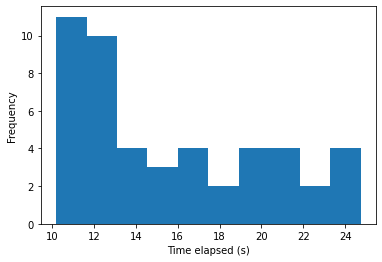

In [31]:
plt.hist([finish_time])
plt.xlabel('Time elapsed (s)')
plt.ylabel('Frequency')

In [23]:
print('Average Time', np.mean(finish_time))

Average Time 14.915185185185184
